In [4]:
import torch
import torch.nn as nn

In [5]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial 
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [6]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016, 
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
    
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

/home/jhk/anaconda3/envs/study/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Training:  17%|█▋        | 41/235 [00:01<00:06, 27.97it/s, epoch=1/1, loss=⠀      0.5452, lr=9.96E-04]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7d40f8012390>>
Traceback (most recent call last):
  File "/home/jhk/anaconda3/envs/study/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Training: 100%|██████████| 235/235 [00:08<00:00, 28.92it/s, epoch=1/1, loss=⠀      0.1490, lr=9.77E-04]

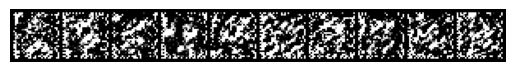

Training: 100%|██████████| 235/235 [00:09<00:00, 24.19it/s, epoch=1/1, loss=⠀      0.1490, lr=9.77E-04]


In [7]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math
from collections import deque

class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2, importance=False, uniform_spread_out=False):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1 
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """
        
        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28), 
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T
        self.min_num_samples = 10
        self.L_t = [deque(maxlen=self.min_num_samples) for i in range(T)]
        self.importance = importance
        self.uniform_spread_out = uniform_spread_out
        #self.reduce = torch.sum if self.importance else torch.mean
        

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        

    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon. 
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index 
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        ''' 

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])
        
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t)) 
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        
        return mean + std*epsilon

    
    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image            
        """
        
        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)            
            xt = self.reverse_diffusion(xt, t, noise)
        return xt

    def compute_t_values(self, k):
       
        u_0 = torch.rand(1)
        i = torch.arange(k).float() 
        t_values = (((u_0 + i / k) % 1)*self.T).to(torch.int)
        
        return t_values

    def sample_t(self, batch_size, device):
        if min(map(len, self.L_t[1:])) < self.min_num_samples or (not self.importance and not self.uniform_spread_out):
            t = torch.randint(1, self.T, (batch_size,1))
            return t.to(device), torch.ones_like(t).to(device).squeeze(1)

        elif self.importance:
            sample_prob = torch.tensor(list(map(lambda x: np.sqrt(np.mean(np.array(x)**2)), self.L_t[1:])))/torch.sum(torch.tensor(list(map(lambda x: np.sqrt(np.mean(np.array(x)**2)), self.L_t[1:]))))
            sample_prob *= 1 - torch.tensor(0.001)
            sample_prob += torch.tensor(0.001)/sample_prob.shape[0]
            t = sample_prob.multinomial(num_samples=batch_size, replacement=True) + 1
            sample_prob = 1/(sample_prob*len(sample_prob))
            return t.to(device).unsqueeze(1), sample_prob[t-1].to(device)
            
        elif self.uniform_spread_out:
            t = self.compute_t_values(batch_size)
            return t.to(device).unsqueeze(1), torch.ones_like(t).to(device)
            
        

    def update_Lt(self, loss, t):
        for i in range(t.shape[0]):
            self.L_t[t[i]].append(loss[i].item())
        
        
    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """

        # Sample time step t
        t, prob = self.sample_t(x0.shape[0], x0.device)

        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)
        loss = -torch.mean(nn.MSELoss(reduction='none')(epsilon, self.network(xt, t)), dim=1)#/prob
        self.update_Lt(loss, t)
        loss = loss*prob
        return loss

    
    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop
    
    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")
    loss_time = []
    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)                
    
    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss_time.append(loss)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)                
        
        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)
    return loss_time

# Parameters
T = 1000
learning_rate = 1e-3
epochs = 1
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T, importance=False, uniform_spread_out=True).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""
    
    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).cpu()
        
        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2 
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()    

# Call training loop
loss = train(model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)



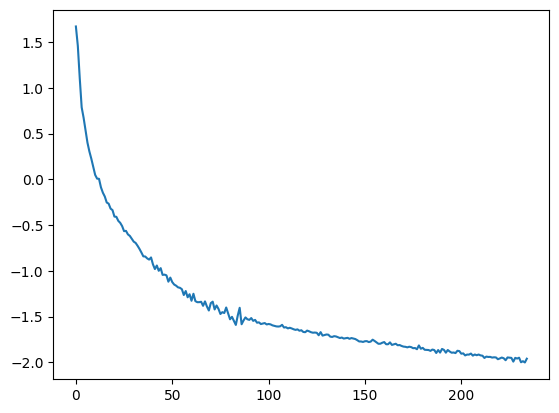

In [5]:
plt.plot(list(map(lambda x: np.log(x.item()), loss)))


Training:  10%|▉         | 234/2350 [00:08<01:14, 28.28it/s, epoch=1/10, loss=⠀      0.1424, lr=9.77E-04]

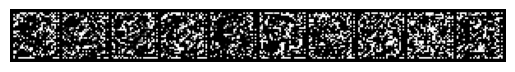


Training:  20%|█▉        | 469/2350 [00:17<01:07, 27.68it/s, epoch=2/10, loss=⠀      0.1088, lr=9.54E-04]

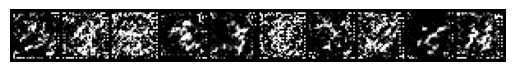


Training:   0%|          | 52/23500 [00:30<3:51:12,  1.69it/s, epoch=1/100, loss=⠀      0.3094, lr=9.95E-04]

Training:  30%|██▉       | 704/2350 [00:27<00:59, 27.82it/s, epoch=3/10, loss=⠀      0.0838, lr=9.32E-04]

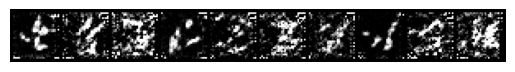


Training:  40%|███▉      | 939/2350 [00:36<00:50, 27.88it/s, epoch=4/10, loss=⠀      0.0803, lr=9.10E-04]

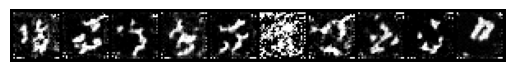


Training:  50%|████▉     | 1174/2350 [00:46<00:42, 27.62it/s, epoch=5/10, loss=⠀      0.0595, lr=8.89E-04]

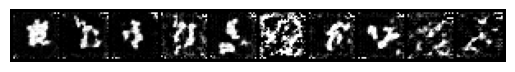


Training:  60%|█████▉    | 1409/2350 [00:55<00:33, 27.70it/s, epoch=6/10, loss=⠀      0.0588, lr=8.68E-04]

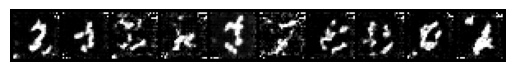


Training:  68%|██████▊   | 1600/2350 [01:03<00:26, 28.05it/s, epoch=7/10, loss=⠀      0.0520, lr=8.52E-04]

In [ ]:
from torch_fidelity import calculate_metrics
import os
from torchvision.transforms import ToPILImage
import shutil
from torch_fidelity.registry import register_feature_extractor
# Assuming you have two directories with real and generated images

transform = transforms.Compose([
    transforms.ToTensor(),
   # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def save_images(tensor_batch, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for i, img in enumerate(tensor_batch):
       # print("HERE",img.shape)
       # print(img.reshape(28,28).shape)
        ToPILImage()(img.reshape(28,28)).save(f"{save_dir}/image_{i+1}.png")

def create_test_folders(model, num_samples, real_images_path, generated_images_path):
    if os.path.exists(real_images_path):
        shutil.rmtree(real_images_path)
    if os.path.exists(generated_images_path):
        shutil.rmtree(generated_images_path)
        
    samples = model.sample((num_samples, 28*28))
    dataloader_test = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=False, transform=transform),
                                                    batch_size=40,
                                                    shuffle=True)
    save_images(samples, generated_images_path)
    save_images(next(iter(dataloader_test))[0], real_images_path)




real_images_path = './true_mnist'
generated_images_path = './generated_mnist'

#register_feature_extractor("new_extractor103", FeatureExtractorInceptionV3_Custom)
losses = []
for importance in [False, True, "NONO"]:
    if not importance == "NONO":
        mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))
        model = DDPM(mnist_unet, T=T, importance=importance).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)
        loss = train(model, optimizer, scheduler, dataloader_train, epochs=10, device=device, ema=True, per_epoch_callback=reporter)
        create_test_folders(model, 100, real_images_path, generated_images_path+f"{str(importance)}") 
        metrics = calculate_metrics(input1=generated_images_path+f"{str(importance)}", input2=real_images_path, fid=True, isc=True, feature_extractor="new_extractor103")
        losses.append(list(map(lambda x: x.item(), loss)))
    else:
        mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))
        model = DDPM(mnist_unet, T=T, importance=False, uniform_spread_out=True).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)
        loss = train(model, optimizer, scheduler, dataloader_train, epochs=10, device=device, ema=True, per_epoch_callback=reporter)
        create_test_folders(model, 100, real_images_path, generated_images_path+f"{str(importance)}") 
        metrics = calculate_metrics(input1=generated_images_path+f"{str(importance)}", input2=real_images_path, fid=True, isc=True, feature_extractor="new_extractor103")
        losses.append(list(map(lambda x: x.item(), loss)))
        
#print(f"FID Score: {fid_score}")


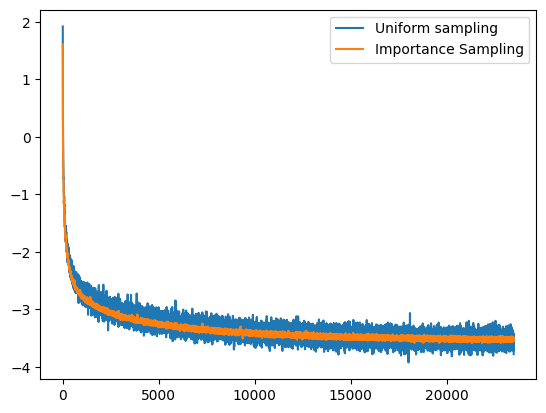

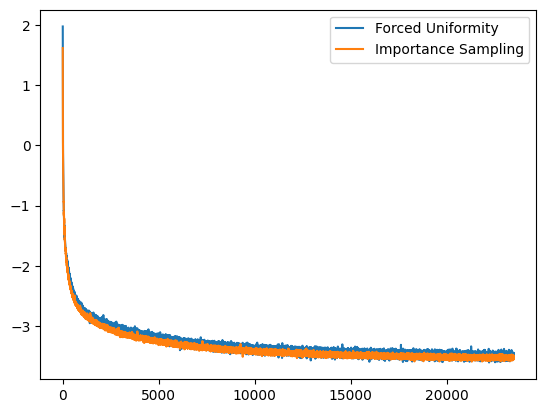

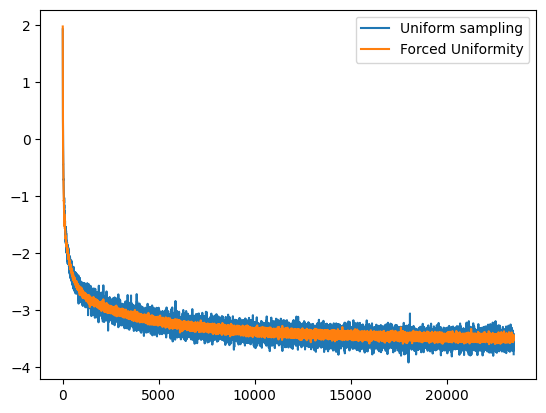

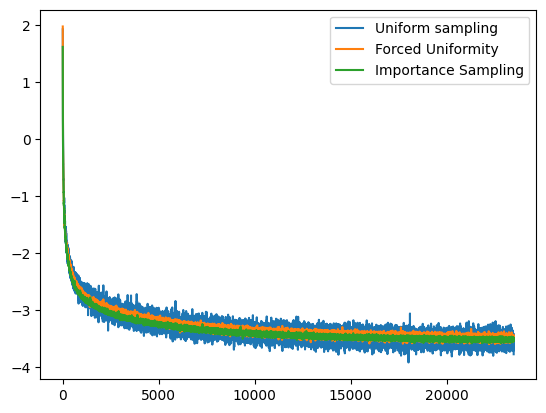

In [14]:
plt.figure(1)
plt.plot(np.log(losses[0]), label='Uniform sampling')
plt.plot(np.log(losses[1]), label='Importance Sampling')
plt.legend()
plt.figure(2)
plt.plot(np.log(losses[2]), label='Forced Uniformity')
plt.plot(np.log(losses[1]), label='Importance Sampling')
plt.legend()
plt.figure(3)
plt.plot(np.log(losses[0]), label='Uniform sampling')
plt.plot(np.log(losses[2]), label='Forced Uniformity')
plt.legend()
plt.figure(4)
plt.plot(np.log(losses[0]), label='Uniform sampling')
plt.plot(np.log(losses[2]), label='Forced Uniformity')
plt.plot(np.log(losses[1]), label='Importance Sampling')
#plt.ylim(0, 2)
plt.legend()
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Set up data transforms
transform = transforms.Compose([
    transforms.Resize(299),  
    transforms.Grayscale(num_output_channels=3),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)




model_incep = FeatureExtractorInceptionV3_Custom(name="new_extractor19", features_list=['64','192','768','2048', 'logits_unbiased','logits'])


#model_incep.fc = nn.Linear(model_incep.fc.in_features, 10)
#print(model_incep)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_incep.to(device)
model_incep.train()
for param in model_incep.parameters():
    param.requires_grad = True

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_incep.parameters(), lr=0.001)
print("Before Training")
# Train the model
for epoch in range(2):  # Train for 5 epochs
    print(epoch)
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        # Forward pass
        
        outputs = model_incep(images)[-1]
        
        # Compute loss

        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total:.2f}%")

# Test the model
model_incep.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_incep(images)[-1]
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        print("here")

print(f"Test Accuracy: {100*correct/total:.2f}%")


Before Training
0
Epoch 1, Loss: 0.13332353963324034, Accuracy: 95.91%
1
Epoch 2, Loss: 0.0531503271485524, Accuracy: 98.39%
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
Test Accuracy: 98.91%


In [51]:
#torch.save(model, "Classifier_mnist.pth")
torch.save(model_incep.state_dict(), "Classifier_mnist.pth")
#torch.save(model, "Classifier_mnist.pth")

In [8]:
#from torch_fidelity import FeatureExtractorInceptionV3

#model = FeatureExtractorInceptionV3_Custom(name="new_extractor", features_list=['64','192','768','2048', 'logits_unbiased','logits'])
#model.fc = nn.Linear(model.fc.in_features, 10)

#model(torch.ones((1,3,299,299), dtype=torch.uint8))

In [8]:
# Portions of source code adapted from the following sources:
#   https://github.com/mseitzer/pytorch-fid/blob/master/src/pytorch_fid/inception.py
#   Distributed under Apache License 2.0: https://github.com/mseitzer/pytorch-fid/blob/master/LICENSE

import sys
from contextlib import redirect_stdout

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.hub import load_state_dict_from_url

from torch_fidelity.feature_extractor_base import FeatureExtractorBase
from torch_fidelity.helpers import vassert, get_kwarg
from torch_fidelity.interpolate_compat_tensorflow import interpolate_bilinear_2d_like_tensorflow1x
def text_to_dtype(name, default=None):
    DTYPES = {
        "uint8": torch.uint8,
        "float32": torch.float32,
        "float64": torch.float32,
    }
    if default in DTYPES:
        default = DTYPES[default]
    return DTYPES.get(name, default)
# InceptionV3 weights converted from the official TensorFlow weights using utils/util_convert_inception_weights.py
#   Original weights distributed under Apache License 2.0: https://github.com/tensorflow/models/blob/master/LICENSE

URL_INCEPTION_V3 = (
    "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth"
)


class FeatureExtractorInceptionV3_Custom(FeatureExtractorBase):
    INPUT_IMAGE_SIZE = 299

    def __init__(
        self,
        name,
        features_list,
        feature_extractor_weights_path=None,
        feature_extractor_internal_dtype=None,
        **kwargs,
    ):
        """
        InceptionV3 feature extractor for 2D RGB 24bit images.

        Args:

            name (str): Unique name of the feature extractor, must be the same as used in
                :func:`register_feature_extractor`.

            features_list (list): A list of the requested feature names, which will be produced for each input. This
                feature extractor provides the following features:

                - '64'
                - '192'
                - '768'
                - '2048'
                - 'logits_unbiased'
                - 'logits'

            feature_extractor_weights_path (str): Path to the pretrained InceptionV3 model weights in PyTorch format.
                Refer to `util_convert_inception_weights` for making your own. Downloads from internet if `None`.

            feature_extractor_internal_dtype (str): dtype to use inside the feature extractor. Specifying it may improve
                numerical precision in some cases. Supported values are 'float32' (default), and 'float64'.
        """
        super(FeatureExtractorInceptionV3_Custom, self).__init__(name, features_list)
        vassert(
            feature_extractor_internal_dtype in ("float32", "float64", None),
            "Only 32 and 64 bit floats are supported for internal dtype of this feature extractor",
        )
        self.feature_extractor_internal_dtype = text_to_dtype(feature_extractor_internal_dtype, "float32")

        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.MaxPool_1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)
        self.MaxPool_2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        self.Mixed_6a = InceptionB(288)
        self.Mixed_6b = InceptionC(768, channels_7x7=128)
        self.Mixed_6c = InceptionC(768, channels_7x7=160)
        self.Mixed_6d = InceptionC(768, channels_7x7=160)
        self.Mixed_6e = InceptionC(768, channels_7x7=192)

        self.Mixed_7a = InceptionD(768)
        self.Mixed_7b = InceptionE_1(1280)
        self.Mixed_7c = InceptionE_2(2048)
        self.AvgPool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.fc = nn.Linear(2048, 10)

        #if feature_extractor_weights_path is None:
        #    with redirect_stdout(sys.stderr):
        #        state_dict = load_state_dict_from_url(URL_INCEPTION_V3, progress=get_kwarg("verbose", kwargs))
       # else:#Classifier_mnist.pth
        state_dict = torch.load("Classifier_mnist.pth")
        self.load_state_dict(state_dict)

        self.to(self.feature_extractor_internal_dtype)
        self.requires_grad_(False)
        self.eval()
        self.transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(299),  # ResNet requires 224x224 images
                transforms.Grayscale(num_output_channels=3),  # Convert MNIST to 3 channels
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
            ])

    def forward(self, x):
        vassert(x.dim() == 4 and x.shape[1] == 3, f"Input is not Bx3xHxW: {x.shape}")
        features = {}
        remaining_features = self.features_list.copy()

        x = x.to(self.feature_extractor_internal_dtype)
        # N x 3 x ? x ?

        x = interpolate_bilinear_2d_like_tensorflow1x(
            x,
            size=(self.INPUT_IMAGE_SIZE, self.INPUT_IMAGE_SIZE),
            align_corners=False,
        )
        # N x 3 x 299 x 299

        # x = (x - 128) * torch.tensor(0.0078125, dtype=torch.float32, device=x.device)  # really happening in graph
        x = (x - 128) / 128  # but this gives bit-exact output _of this step_ too
        # N x 3 x 299 x 299

        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.MaxPool_1(x)
        # N x 64 x 73 x 73

        if "64" in remaining_features:
            features["64"] = F.adaptive_avg_pool2d(x, output_size=(1, 1)).squeeze(-1).squeeze(-1).to(torch.float32)
            remaining_features.remove("64")
            if len(remaining_features) == 0:
                return tuple(features[a] for a in self.features_list)

        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.MaxPool_2(x)
        # N x 192 x 35 x 35

        if "192" in remaining_features:
            features["192"] = F.adaptive_avg_pool2d(x, output_size=(1, 1)).squeeze(-1).squeeze(-1).to(torch.float32)
            remaining_features.remove("192")
            if len(remaining_features) == 0:
                return tuple(features[a] for a in self.features_list)

        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17

        if "768" in remaining_features:
            features["768"] = F.adaptive_avg_pool2d(x, output_size=(1, 1)).squeeze(-1).squeeze(-1).to(torch.float32)
            remaining_features.remove("768")
            if len(remaining_features) == 0:
                return tuple(features[a] for a in self.features_list)

        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        x = self.AvgPool(x)
        # N x 2048 x 1 x 1

        x = torch.flatten(x, 1)
        # N x 2048

        if "2048" in remaining_features:
            features["2048"] = x.to(torch.float32)
            remaining_features.remove("2048")
            if len(remaining_features) == 0:
                return tuple(features[a] for a in self.features_list)

        if "logits_unbiased" in remaining_features:
            x = x.mm(self.fc.weight.T)
            # N x 1008 (num_classes)
            features["logits_unbiased"] = x.to(torch.float32)
            remaining_features.remove("logits_unbiased")
            if len(remaining_features) == 0:
                return tuple(features[a] for a in self.features_list)

            x = x + self.fc.bias.unsqueeze(0)
        else:
            x = self.fc(x)
            # N x 1008 (num_classes)

        features["logits"] = x.to(torch.float32)
        return tuple(features[a] for a in self.features_list)

    @staticmethod
    def get_provided_features_list():
        return "64", "192", "768", "2048", "logits_unbiased", "logits"

    @staticmethod
    def get_default_feature_layer_for_metric(metric):
        return {
            "isc": "logits_unbiased",
            "fid": "2048",
            "kid": "2048",
            "prc": "2048",
        }[metric]

    @staticmethod
    def can_be_compiled():
        return True

    @staticmethod
    def get_dummy_input_for_compile():
        return (torch.rand([1, 3, 4, 4]) * 255).to(torch.uint8)


class BasicConv2d(nn.Module):
    """Original BasicConv2d block"""

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class InceptionA(nn.Module):
    """Block from torchvision patched to be compatible with TensorFlow implementation"""

    def __init__(self, in_channels, pool_features):
        super(InceptionA, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)

        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1, count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):
    """Original block"""

    def __init__(self, in_channels):
        super(InceptionB, self).__init__()
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):
    """Block from torchvision patched to be compatible with TensorFlow implementation"""

    def __init__(self, in_channels, channels_7x7):
        super(InceptionC, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1, count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionD(nn.Module):
    """Original block"""

    def __init__(self, in_channels):
        super(InceptionD, self).__init__()
        self.branch3x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = BasicConv2d(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = BasicConv2d(192, 192, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return torch.cat(outputs, 1)


class InceptionE_1(nn.Module):
    """First InceptionE block from torchvision patched to be compatible with TensorFlow implementation"""

    def __init__(self, in_channels):
        super(InceptionE_1, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: Tensorflow's average pool does not use the padded zero's in its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1, count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class InceptionE_2(nn.Module):
    """Second InceptionE block from torchvision patched to be compatible with TensorFlow implementation"""

    def __init__(self, in_channels):
        super(InceptionE_2, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: TensorFlow Inception model uses max pooling instead of average
        # pooling. This is likely an error in this specific Inception
        # implementation, as other Inception models use average pooling here
        # (which matches the description in the paper).
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)